100%|██████████| 2000/2000 [00:02<00:00, 737.72it/s]
/Users/leehaesung/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


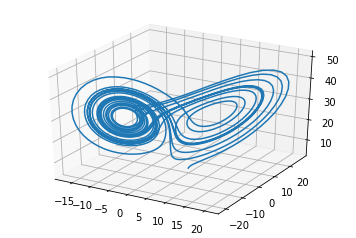

In [3]:
import tensorflow_diff_eq.diff_eq as diff_eq
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from mpl_toolkits.mplot3d import Axes3D # Added

eq = diff_eq.DifferentialEquation()

# Define the quantities,
(x,y,z) = eq.generate_quantities(3)
# and the parameters
sigma = 12.0
rho = 29.0
beta = 7.0/3.0

eq.prepare_quantity_for_recursive_definition(x, 4.0, 0, 1)
eq.prepare_quantity_for_recursive_definition(y, 2.0, 0, 1)
eq.prepare_quantity_for_recursive_definition(z, 3.0, 0, 1)
# The Lorenz equations
eq.define_quantity_recursively(x, sigma * (y.d(0)-x.d(0)))
eq.define_quantity_recursively(y, x.d(0)*(rho - z.d(0))-y.d(0))
eq.define_quantity_recursively(z, x.d(0)*y.d(0) - z.d(0)*beta)

# Start tensorflow
sess = tf.Session()
sess.run(tf.global_variables_initializer())
simulate_op = eq.generate_simulate_operation(0.005)

N = 2000
xs = np.zeros(N)
ys = np.zeros(N)
zs = np.zeros(N)
ts = np.zeros(N)
(x,y,z) = (x.d(0),y.d(0),z.d(0))
for i in tqdm.tqdm(range(N)):
    xs[i] = sess.run(x)
    ys[i] = sess.run(y)
    zs[i] = sess.run(z)
    if i < N - 1:
        sess.run(simulate_op)
        sess.run(simulate_op)
        ts[i+1] = ts[i] + 0.01

np.save("lorenz_sim_data", [xs, ys, zs])

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(xs, ys, zs)
ax.legend()

plt.show()

# Visualize a tensorflow graph 

In [4]:
# Functions to show the Graphs
import numpy as np
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [5]:
show_graph(tf.get_default_graph())

In [ ]:
# END